# <div align="center">YOLO Parking Spot  🚗🅿️</div>
<hr>

### Authors
- #### [Matheus Silva](https://www.github.com/matheuxito)
- #### [Marcos Lucas](https://www.github.com/lmarcosz)

### In this notebook, you can assess the performance of the models in prediction and determine if they have achieved satisfactory results

- [Processing the parking lot images](#section-1)
    - [Without YOLO](#without-yolo)
    - [YOLOv5](#yolov5-model)
        - [Trained YOLOv5n](#my-yolov5n)
        - [Trained YOLOv5s](#my-yolov5s)
    - [YOLOv8](#yolov8-model)
        - [Trained YOLOv8n](#my-yolov8n)
        - [Trained YOLOv8s](#my-yolov8s)
    - [Custom model](#custom-model)
- [Comparing the Models](#section-2)
    - [Size Comparison](#size)
    - [Parameters Comparison](#params)
    - [GFLOPs Comparison](#gflops)
    - [Precision and Recall Comparison](#precision-recall)
    - [mAP Comparison](#map)
- [Comparing the Results](#section-3)
- [Conclusion](#conclusion)


In [1]:
import pandas as pd
import sys
import os

# Add the path to the utils folder to the system path
if os.path.basename(os.getcwd()) == 'notebooks':
    sys.path.append('../')

from utils.functions import process_images, get_results_df
from utils.functions import plot_model_size, plot_model_params, plot_model_gflops, plot_precision_recall, plot_mAP, save_plots

# Get current working directory
repo_path = os.path.dirname(os.getcwd())

## <div id="section-1">Processing the parking lot images</div>
<hr>

### <div id="without-yolo">Without YOLO</div>
The following cell generates the images that we will be using to compare the custom models later on.

In [2]:
# Specify the folder path containing the images and annotations
data_path = os.path.join(repo_path, 'data')

# Specify the output folder path
output_folder = os.path.join(repo_path, 'results/without_yolo/')

# process_images returns a dataframe containing the results
without_yolo_results = process_images(data_path, output_folder, highlighted_cars=True)
without_yolo_results.head(5) # Show the results for the first 5 images

Processing images...
Processed 23 images ✅


,Image File,Disabled parking spots,Parking spots,Cars,Empty disabled parking spots,Occupied disabled parking spots,Empty parking spots,Occupied parking spots,Cars in transit or parked in non-parking spots
0,empty_set1_60m_1.jpg,20,70,1,20,0,69,1,0
1,empty_set1_60m_2.jpg,20,70,1,20,0,69,1,0
2,empty_set1_65m_1.jpg,22,77,0,22,0,77,0,0
3,empty_set1_70m_2.jpg,22,77,1,22,0,76,1,0
4,empty_set1_75m_1.jpg,22,77,0,22,0,77,0,0


### <div id="yolov5-model">YOLOv5</div>
The following cell will generate the processed images with the labels provided by the YOLOv5 model's prediction.

#### <div id="my-yolov5n">Predictions provided by my trained YOLOv5n model

In [3]:
# Specify the model name
model = 'my_yolov5n'

# Specify the folder path containing the images and annotations
data_path = os.path.join(repo_path, 'data')

# Specify the output folder path
output_folder = f'{repo_path}/results/{model}/'

# process_images returns a dataframe containing the results
yolov5n_results = process_images(data_path, output_folder, highlighted_cars=True, model=model)
yolov5n_results.head(5) # Show the results for the first 5 images

Using labels from c:\Users\mathe\Documents\Projects\YOLO-Parking-Spot\results/my_yolov5n/labels/
Processing images...
Processed 23 images ✅


,Image File,Disabled parking spots,Parking spots,Cars,Empty disabled parking spots,Occupied disabled parking spots,Empty parking spots,Occupied parking spots,Cars in transit or parked in non-parking spots
0,empty_set1_60m_1.jpg,20,70,1,20,0,69,1,0
1,empty_set1_60m_2.jpg,20,70,1,20,0,69,1,0
2,empty_set1_65m_1.jpg,22,77,0,22,0,77,0,0
3,empty_set1_70m_2.jpg,22,77,1,22,0,76,1,0
4,empty_set1_75m_1.jpg,22,77,0,22,0,77,0,0


#### <div id="my-yolov5s">Predictions provided by my trained YOLOv5s model</div>

In [4]:
model = 'my_yolov5s'
output_folder = f'{repo_path}/results/{model}/'
yolov5s_results = process_images(data_path, output_folder, highlighted_cars=True, model=model)
yolov5s_results.head() # Show the results for the first 5 images

Using labels from c:\Users\mathe\Documents\Projects\YOLO-Parking-Spot\results/my_yolov5s/labels/
Processing images...
Processed 23 images ✅


,Image File,Disabled parking spots,Parking spots,Cars,Empty disabled parking spots,Occupied disabled parking spots,Empty parking spots,Occupied parking spots,Cars in transit or parked in non-parking spots
0,empty_set1_60m_1.jpg,20,70,1,20,0,69,1,0
1,empty_set1_60m_2.jpg,20,70,1,20,0,69,1,0
2,empty_set1_65m_1.jpg,22,77,0,22,0,77,0,0
3,empty_set1_70m_2.jpg,22,77,1,22,0,76,1,0
4,empty_set1_75m_1.jpg,22,77,0,22,0,77,0,0


### <div id="yolov8-model">YOLOv8</div>

The following cell will generate the processed images with the labels provided by the YOLOv8 model's predictions.

#### <div id="my-yolov8n">Predictions provided by my trained YOLOv8n model

In [5]:
# Specify the model name
model = 'my_yolov8n'

# Specify the folder path containing the images and annotations
data_path = os.path.join(repo_path, 'data')

# Specify the output folder path
output_folder = f'{repo_path}/results/{model}/'

# process_images returns a dataframe containing the results
yolov8n_results = process_images(data_path, output_folder, highlighted_cars=True, model=model)
yolov8n_results.head() # Show the results for the first 5 images

Using labels from c:\Users\mathe\Documents\Projects\YOLO-Parking-Spot\results/my_yolov8n/labels/
Processing images...
Processed 23 images ✅


,Image File,Disabled parking spots,Parking spots,Cars,Empty disabled parking spots,Occupied disabled parking spots,Empty parking spots,Occupied parking spots,Cars in transit or parked in non-parking spots
0,empty_set1_60m_1.jpg,20,70,1,20,0,69,1,0
1,empty_set1_60m_2.jpg,20,70,1,20,0,69,1,0
2,empty_set1_65m_1.jpg,22,77,0,22,0,77,0,0
3,empty_set1_70m_2.jpg,22,77,1,22,0,76,1,0
4,empty_set1_75m_1.jpg,22,77,0,22,0,77,0,0


#### <div id="my-yolov8s">Predictions provided by my trained YOLOv8s model

In [6]:
model = 'my_yolov8s'
output_folder = f'{repo_path}/results/{model}/'
yolov8s_results = process_images(data_path, output_folder, highlighted_cars=True, model=model)
yolov8s_results.head() # Show the results for the first 5 images

Using labels from c:\Users\mathe\Documents\Projects\YOLO-Parking-Spot\results/my_yolov8s/labels/
Processing images...
Processed 23 images ✅


,Image File,Disabled parking spots,Parking spots,Cars,Empty disabled parking spots,Occupied disabled parking spots,Empty parking spots,Occupied parking spots,Cars in transit or parked in non-parking spots
0,empty_set1_60m_1.jpg,20,70,1,20,0,69,1,0
1,empty_set1_60m_2.jpg,20,70,1,20,0,69,1,0
2,empty_set1_65m_1.jpg,22,77,0,22,0,77,0,0
3,empty_set1_70m_2.jpg,22,77,1,22,0,76,1,0
4,empty_set1_75m_1.jpg,22,77,0,22,0,77,0,0


### <div id="custom-model">Custom model</div>

#### If you want to train a model from scratch or make predictions with your trained model, go to the [yolov5](yolov5.ipynb) or [yolov8](yolov8.ipynb) notebooks ✨🚀

To use your **trained model** predictions, specify the model path and the labels directory in `output_folder`!<br>
Example:
```python
# Specify the model path or the model name if it is in the models folder.
model_path = f'{repo_path}models/yolov5n/runs/exp/weights/best.pt'
# model = "my_yolovXX.pt"

# Specify the output folder path
output_folder = f'{repo_path}/results/{model}/'

# process_images returns a dataframe containing the results
results = process_images(data_path, output_folder, highlighted_cars=True, model=model_path)
results.head(20) # # Show the results for the first 20 images
```

In [7]:
# Specify the model path or the model name if it is in the models folder.
#model_path = f'{repo_path}models/yolov5n/runs/exp/weights/best.pt'
#model = "my_yolovXX.pt"

# Specify the output folder path
#output_folder = f'{repo_path}/results/{model}/'

# process_images returns a dataframe containing the results
#results = process_images(data_path, output_folder, highlighted_cars=True, model=model_path)
#results.head(20) # # Show the results for the first 20 images

## <div id="section-2">Comparing the Models</div>
<hr>

First of all, let's get the model summaries from the "models" folder.

In [8]:
# Path to the CSV file
filename = f'{repo_path}/models/models_summary.csv'

# Import the CSV file into a pandas DataFrame
models_summary = pd.read_csv(filename, thousands='.', decimal=',')

# Show the models summary
models_summary.head()

,Model,Model Size (MB),Layers,Parameters,GFLOPs,Instances,Precision,Recall,mAP0-50,mAP50-95
0,YOLOv5n,4.8,157,1760518,4.1,296,0.999,0.993,0.995,0.774
1,YOLOv5s,15.3,157,7012822,15.8,292,1.000,0.995,0.995,0.800
2,YOLOv8n,6.2,168,3005843,8.1,308,0.978,0.987,0.995,0.810
3,YOLOv8s,22.7,168,11125971,28.4,195,0.999,1.000,0.995,0.805


### <div id="size">Size Comparison</div>

This bar plot shows the model size in MB for each model. It provides a visual comparison of the size differences among the models.

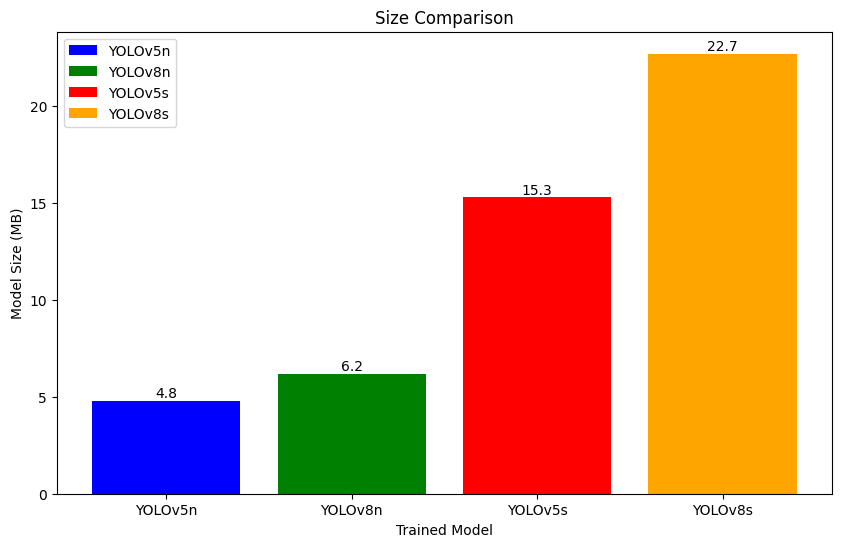

In [9]:
plot_model_size(models_summary)

### <div id="params">Parameters Comparison</div>

This bar plot shows the number of model parameters for each model. It provides a visual comparison of the differences in parameters among the models.

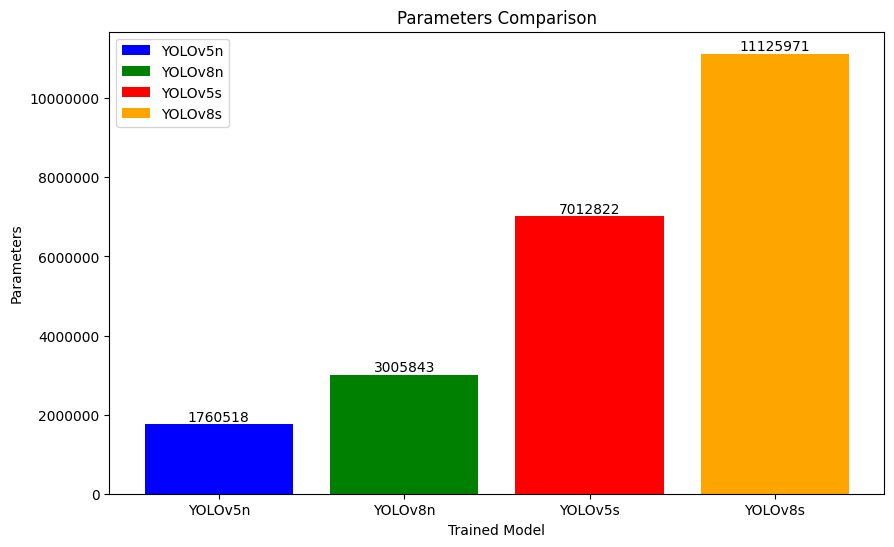

In [10]:
plot_model_params(models_summary)

The YOLOv5 models have 157 layers, while the YOLOv8 models have 168 layers.

### <div id="gflops">GFLOPs Comparison</div>

This bar plot shows the GFLOPs (giga floating-point operations) for each model, providing a visual comparison of the differences in GFLOPs among the models.

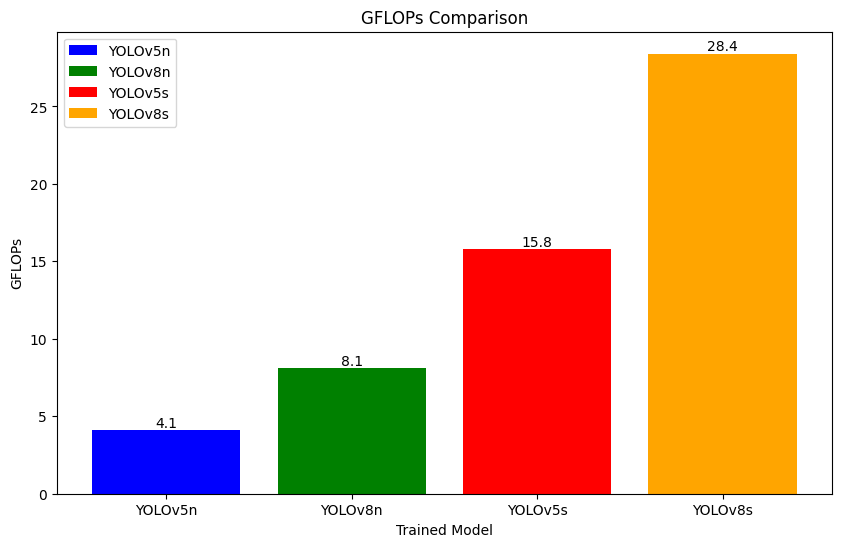

In [11]:
plot_model_gflops(models_summary)

### <div id="precision-recall">Precision and Recall Comparison</div>

This line plot compares the precision and recall scores for each model. It helps in understanding the trade-off between precision and recall among different models.

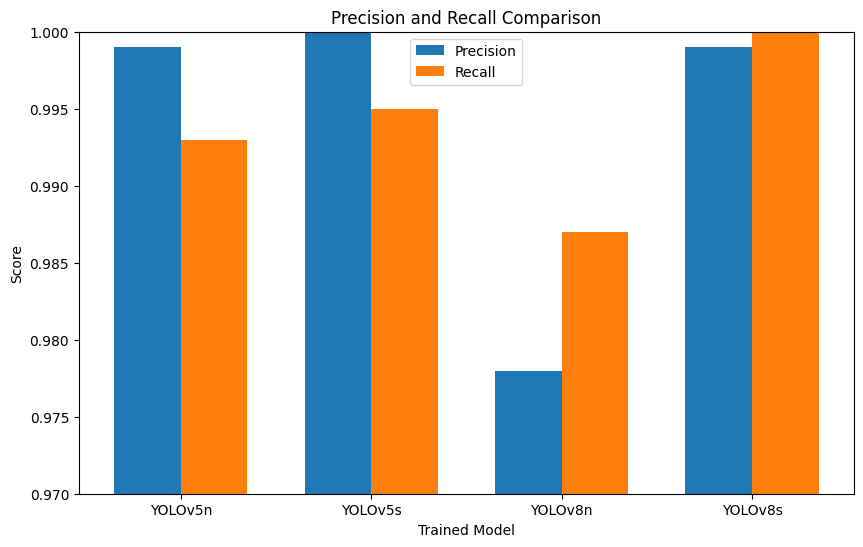

In [12]:
plot_precision_recall(models_summary)

### <div id="map">mAP 50-95 Comparison</div>

This bar plot compares the mAP50-95 scores for each model. It provides insights into the overall performance of the models in terms of mean Average Precision (mAP50-95).

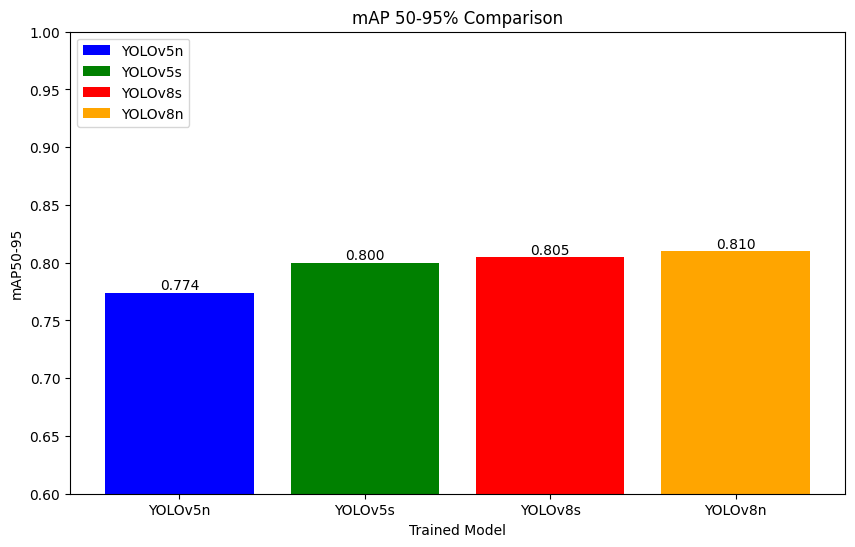

In [13]:
plot_mAP(models_summary)

In [14]:
save_plots()

## <div id="section-3">Comparing the Results</div>
<hr>

In [15]:
results_df = get_results_df(without_yolo_results, yolov5n_results, yolov5s_results, yolov8n_results, yolov8s_results)
results_df.head()

,Model,Cars MAE,Occupied disabled parking spots MAE,Empty disabled parking spots MAE,Occupied parking spots MAE,Empty parking spots MAE,Cars in transit or parked in non-parking spots MAE
0,YOLOv5n,0.695652,0.0,0.0,0.0,0.0,0.695652
1,YOLOv5s,0.652174,0.0,0.0,0.0,0.0,0.652174
2,YOLOv8n,0.782609,0.0,0.0,0.0,0.0,0.782609
3,YOLOv8s,0.695652,0.0,0.0,0.0,0.0,0.695652


The table above displays the Mean Absolute Error (MAE) values for different columns based on the predictions made by various models. The MAE values indicate how well the models performed in their respective tasks. Overall, the models achieved good results, particularly in identifying occupied and empty parking spots. 

However, there is an interesting observation regarding the "Cars" column. The MAE values for this column indicate that the models had some errors in predicting the number of cars identified in the images. Upon further analysis, it was discovered that these errors were not due to any shortcomings of the models themselves. Rather, the errors occurred because there were instances where cars were not manually marked during the dataset creation process.

In other words, the models were able to detect cars in certain positions that were initially overlooked during the manual annotation of the dataset. This realization highlights that the models performed well in identifying cars, even in unexpected positions. The errors observed in the "Cars" column can be attributed to human error during the dataset labeling phase, where some cars were incorrectly assumed to be undetectable by the models.

These results emphasize the capabilities of the models in accurately identifying occupied and empty parking spots. It also underscores the importance of thorough and precise dataset labeling to ensure accurate evaluation and performance assessment of the models.

## <div id="conclusion">Conclusion</div>
<hr>

Based on the analysis presented, it can be concluded that all four models achieved excellent results for the parking lot at ICT Unifesp. However, based on certain factors, the YOLOv5n model can be considered the best option for this particular case.

The YOLOv5n model demonstrated impressive performance in accurately identifying occupied and empty parking spots, as indicated by the consistently low MAE values across multiple columns. Additionally, it has the advantage of being the lightest in terms of file size (in MB) and having the fewest parameters compared to the other models. This translates into faster processing speed and lower memory usage, making it a practical choice for real-time applications.

To further improve our work, it is recommended to create a larger and more precisely labeled dataset. By expanding the dataset and ensuring accurate labeling of cars and corresponding labels, we can enhance the training process and increase the model's ability to detect cars in various positions and conditions accurately.

By investing in a more comprehensive and accurately labeled dataset, we can train a model that is tailored specifically to the ICT Unifesp parking lot, optimizing its performance and ensuring it meets the specific requirements of our study. With continued efforts to refine the dataset and fine-tune the model, we can strive for even better results and contribute to the advancement of parking spot detection and monitoring systems.